ДЗ 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Проверим как численно находить градиент функции f(x). Для этого помимо самой функции f(x) определим ее производную.

In [2]:
def f(x):
    return x**3 - 3*x**2 + 2*x - 5
    #return 2*x - 5

def f_deriv(x):
    return 3*x**2 - 6*x + 2

Формируем тренировочный датасет.

In [3]:
x_min = 0
x_max = 5
points = 1000

delta_x = np.abs(x_max - x_min) / points

X_train = np.linspace(x_min, x_max, points + 1)
y_train = f(X_train)

# Проверка шага.
print(delta_x)
print(X_train[1] - X_train[0])

0.005
0.005


<function matplotlib.pyplot.show(close=None, block=None)>

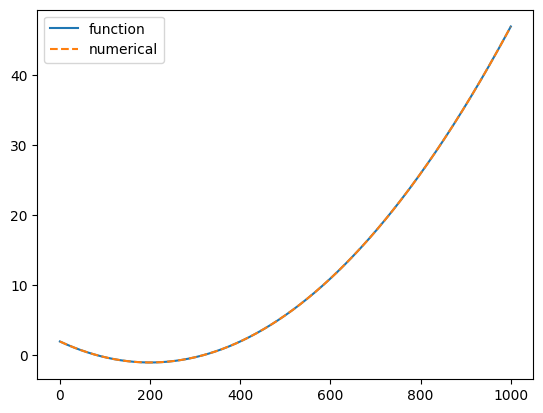

In [4]:
plt.plot(f_deriv(X_train))
plt.plot(np.gradient(y_train, X_train), '--')
plt.legend(['function', 'numerical'])
plt.show

In [5]:
def func_targ(X, w_coeff):
    Y = np.zeros_like(X)
    for n, x in enumerate(X):
        for idx, w in enumerate(w_coeff.tolist()[0]):
            Y[n] = Y[n] + w * x**idx
    return Y

def loss_func(X, y, w_coeff):
    #print(np.sum((y - func_targ(X, w_coeff))**2))
    return np.sum((y - func_targ(X, w_coeff))**2)

In [6]:
max_iterations = 50000
lr = [1e-4, 1e-5, 1e-6, 1e-7]
#lr = [1e-4, 1e-6]
tol = 1e-4
# Weights.
K = 4
w_coeff = np.zeros((1,K))
#w_coeff = np.array([[-5, 2]])
#w_coeff[0,0] = -5
#w_coeff[0,1] = 1

w_grad = np.ones_like(w_coeff)
w_coeff_lr = w_coeff.copy()

for i in range(max_iterations):
    for idx, w in enumerate(w_coeff.tolist()[0]):
        w_coeff_u = w_coeff.copy()
        w_step = - lr[idx] * w_grad[0,idx]
        w_coeff_u[0,idx] = w + w_step
        w_coeff_lr[0,idx] = w_coeff_u[0,idx]
        w_grad[0,idx] = np.gradient([loss_func(X_train, y_train, w_coeff), loss_func(X_train, y_train, w_coeff_u)], w_step)[0]
        #print(w_grad[0,idx])
        #print(loss_func(X_train, y_train, w_coeff_u) - loss_func(X_train, y_train, w_coeff))
    w_coeff = w_coeff_lr.copy()
    print('Iter', i)
    print('Gradient', w_grad)
    print('Loss', loss_func(X_train, y_train, w_coeff))
    print('Weights', w_coeff)
    if loss_func(X_train, y_train, w_coeff) < tol:
        break

Iter 0
Gradient [[  -12550.13759888   -71108.66261646  -334709.89606576 -1533669.27115712]]
Loss 304505.80716036935
Weights [[-1.e-04 -1.e-05 -1.e-06 -1.e-07]]
Iter 1
Gradient [[  -11294.04193053   -65174.72084059  -292769.01777394 -1190143.04098254]]
Loss 82868.20665780018
Weights [[1.25491376 0.71107663 0.3347089  0.15336683]]
Iter 2
Gradient [[ 9843.23120478 11879.49092222 11579.07733414 26495.56395849]]
Loss 193686.41343551694
Weights [[2.38431795 1.36282383 0.62747791 0.27238113]]
Iter 3
Gradient [[ 25590.5356638   70142.77978276 230828.57079045 827105.12934969]]
Loss 156436.1099730426
Weights [[1.39999483 1.24402893 0.61589884 0.26973157]]
Iter 4
Gradient [[ 21089.84424905  56981.61052049 173814.03030388 532387.64366863]]
Loss 55068.19678064712
Weights [[-1.15905873  0.54260113  0.38507027  0.18702106]]
Iter 5
Gradient [[   3873.82556534   -1621.05805639  -49950.15011419 -349358.62236058]]
Loss 117742.12472590743
Weights [[-3.26804316 -0.02721498  0.21125624  0.1337823 ]]
Iter 6


KeyboardInterrupt: 

f1(x)=x^3−3x^2+2x−5

f2(x)=w3.x^3 + w2.x^2 + w1.x + w0

где ожидаемые значения весов:

w0 = -5

w1 = 2

w2 = -3

w3 = 1